Install dependencies for computing metrics and plots:

In [1]:
#!pip3 install numpy scipy pandas seaborn matplotlib sklearn

## Basic imports

In [100]:
import jax
import jax.numpy as jnp
import flax
from entmax_jax import sparsemax
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from functools import partial
import json

from meta_expl.explainers import load_explainer
from meta_expl.models import load_model
from meta_expl.data.mlqe import dataloader

from evaluate_explanations import evaluate_word_level, evaluate_sentence_level, aggregate_pieces

In [122]:
# plot utils
def detokenize(pieces):
    return ''.join(pieces).replace('▁', ' ').replace('</s>', ' </s>')

def colorize_twoway(words, color_array, label='GOLD', max_width_shown=1800):
    template_pos = '<span class="barcode"; style="color: black; background-color: rgba(0, 255, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    template_neg = '<span class="barcode"; style="color: black; background-color: rgba(255, 0, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    colored_string = ''
    f = lambda w: w.replace('<', 'ᐸ').replace('>', 'ᐳ')
    for word, color in zip(words, color_array / color_array.abs().max()):
        if color > 0:
            colored_string += template_pos.format(color, f(word))
        else:
            colored_string += template_neg.format(-color, f(word))
    html_text = '<div style="100%">{}:&nbsp;&nbsp; {}</div>'.format(label, colored_string)
    display(HTML(html_text))

In [101]:
# data utils
def read_data(lp, split='dev'):
    def tags_to_ints(line):
        return list(map(int, line.strip().replace('OK', '0').replace('BAD', '1').split()))
    data = {
        'original': [line.strip() for line in open('data/{}/{}.src'.format(lp, split), 'r')],
        'translation': [line.strip() for line in open('data/{}/{}.mt'.format(lp, split), 'r')],
        'da': [float(line.strip()) for line in open('data/{}/{}.da'.format(lp, split), 'r')],
        'src_tags': [tags_to_ints(line) for line in open('data/{}/{}.src-tags'.format(lp, split), 'r')],
        'mt_tags': [tags_to_ints(line) for line in open('data/{}/{}.tgt-tags'.format(lp, split), 'r')]
    }
    z = np.array(data['da'])
    data['z_mean'] = (z - z.mean()) / z.std()
    data = [dict(zip(data.keys(), v)) for v in list(zip(*data.values()))]
    return data

In [5]:
# arguments
arch = 'xlm-roberta-base'
arch_mtl = 'xlm-r'
setup = 'no_teacher'  # "no_teacher", "static_teacher", "learnable_teacher"
lp = 'ro-en'
max_len = 256
batch_size = 1
seed = 1
sep_token = "</s>" if 'xlm' in arch else "[SEP]"
num_classes = 1
teacher_dir = 'data/mlqe-xlmr-explainer/teacher_dir'
explainer_dir = 'data/mlqe-xlmr-explainer/teacher_expl_dir'

In [6]:
# create dummy inputs for model instantiation
input_ids = jnp.ones((batch_size, max_len), jnp.int32)
dummy_inputs = {
    "input_ids": input_ids,
    "attention_mask": jnp.ones_like(input_ids),
    "token_type_ids": jnp.arange(jnp.atleast_2d(input_ids).shape[-1]),
    "position_ids": jnp.ones_like(input_ids),
}

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [12]:
# load data
dataloader = partial(dataloader, sep_token=sep_token)
train_data = read_data(lp, "train")
valid_data = read_data(lp, "dev")

In [8]:
from transformers import XLMRobertaTokenizerFast
tokenizer = XLMRobertaTokenizerFast.from_pretrained(arch)

In [9]:
teacher, teacher_params, dummy_state = load_model(teacher_dir, batch_size, max_len)
explainer, explainer_params = load_explainer(explainer_dir, dummy_inputs)

TypeError: __call__() got an unexpected keyword argument 'unnorm_attention'

## Evaluating explanations by comparing explanations with word-level QE tags

In [15]:
# get predictions
def get_predictions_and_explanations(data):
    all_outputs = []
    all_explanations_src, all_explanations_mt = [], []
    for x, y in dataloader(data, tokenizer, batch_size=batch_size, max_len=max_len, shuffle=False):
        outputs = explainer.apply(explainer_params, **x)[0]
        all_outputs.append(outputs)
        
        #todo:
        best_layer_id = 1
        best_head_id = 1
        src_explanation = explainer.attention.coefficients[best_layer_id][best_head_id]
        src_explanation = aggregate_pieces(torch.from_numpy(src_explanations)).numpy()
        all_expanations_src.append(src_explanation)

    return all_outputs, all_explanations_src, all_explanations_mt


In [ ]:
scores_pred, explanations_src_pred, explanations_mt_pred = get_predictions_and_explanations(valid_data)

In [59]:
# simulating predictions
explanations_src_gold = [inp['mt_tags'] for inp in valid_data]
explanations_mt_gold = [inp['mt_tags'] for inp in valid_data]
scores_gold = [inp['z_mean'] for inp in valid_data]
explanations_src_pred = []
explanations_mt_pred = []
scores_pred = []
softmax = lambda x: np.exp(x) / np.exp(x).sum()
for inp in valid_data:
    explanations_src_pred.append(softmax(np.random.randn(len(inp['src_tags']))))
    explanations_mt_pred.append(softmax(np.random.randn(len(inp['mt_tags']))))
    scores_pred.append(np.random.randn(1)[0])

In [60]:
_ = evaluate_word_level(explanations_mt_gold, explanations_mt_pred)

AUC score: 0.5004
AP score: 0.3655
Recall at top-K: 0.2504


In [61]:
_ = evaluate_sentence_level(scores_gold, scores_pred)

Pearson: -0.0440
Spearman: -0.0298
MAE: 1.1792
RMSE: 1.4766


## Visualizing explanations

In [56]:
def show_explanation(tokens, tags, explanation):
    import torch
    colorize_twoway(tokens.split(), torch.tensor(tags), label='gold')
    colorize_twoway(tokens.split(), torch.tensor(explanation), label='pred')

In [123]:
print('SRC:')
print('----')
show_explanation(valid_data[0]['original'], explanations_src_gold[0], explanations_src_pred[0])

print('MT:')
print('----')
show_explanation(valid_data[0]['translation'], explanations_mt_gold[0], explanations_mt_pred[0])

SRC:
----


MT:
----


## Plotting the distribution of predictions and AUC scores

In [130]:
# define options for seaborn
custom_params = {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.color': '.85',
    'grid.linestyle': ':'
}
_ = sns.set_theme(style='whitegrid', rc=custom_params),

def plot_da_vs_expl_metric(metric_fn, das, e_golds, e_preds):
    x = []
    y = []
    for da, gold, pred in zip(das, e_golds, e_preds):
        if sum(gold) == 0 or sum(gold) == len(gold):
            continue
        y.append(metric_fn(gold, pred))
        x.append(da)
    x = np.array(x)
    y = np.array(y)
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    sns.regplot(x=x, y=y, ax=axs[0], color='tab:green')
    axs[0].set_xlabel('da')
    axs[0].set_ylabel(str(metric_fn).split()[1])
    sns.histplot(x, bins=20, ax=axs[1], color='green')
    axs[1].set_xlabel('da')
    sns.histplot(y, bins=20, ax=axs[2], color='green')
    axs[2].set_xlabel(str(metric_fn).split()[1])

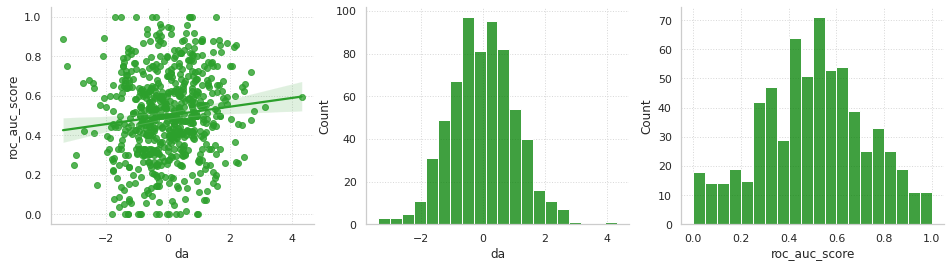

In [131]:
# plot predicted DA vs AUC
from sklearn.metrics import roc_auc_score, average_precision_score
plot_da_vs_expl_metric(roc_auc_score, scores_pred, explanations_mt_gold, explanations_mt_pred)

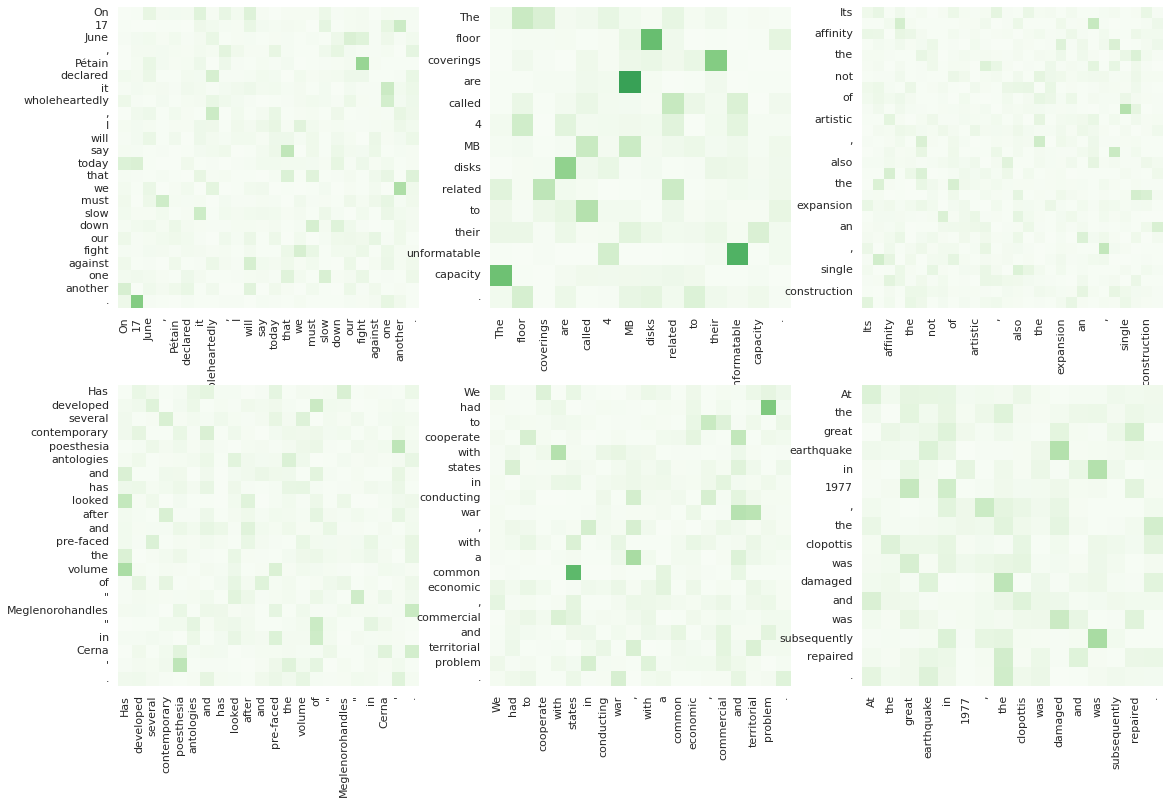

In [119]:
fig, axs = plt.subplots(2, 3, figsize=(16, 11))
fig.tight_layout(pad=3)
for i in range(6):
    ax = axs[i//3, i%3]
    tokens = valid_data[i]['translation'].split()
    n = len(tokens)
    A = np.stack([softmax(np.random.randn(n)) for _ in range(n)])
    df = pd.DataFrame(A, columns=tokens, index=tokens)
    sns.heatmap(df, vmax=1, cmap="Greens", square=True, cbar=False, ax=ax)